<center><h1>Datos Meteorológicos con Métodos de Interpolación</h1></center>  
<center><img src="clima.png" width=270 height=270></center>  

### **Sección: 305C1**
### **Estudiantes:**
Manuel Nava 30.822.007  
Juan Wu 30.391.117  
José Farrauto 30.696.288  

---

## Datos Metereológicos utilizados:

Los datos metereológicos utilizado para el desarrollo de las interpolaciones se basan en las temperaturas altas y bajas de la ciudad Tokio, Japón la semana desde el 23 al 29 de diciembre del año 2023 extraídos de la página web: *https://www.accuweather.com/es/jp/tokyo/226396/weather-forecast/226396*


---


## Interpolación de Taylor

Las temperaturas medias de cada dia son: [15.5, 12.5, 8.0, 7.0, 9.5, 7.5, 6.0]
La predicción sobre el punto x0 es: 10.6906752000000 


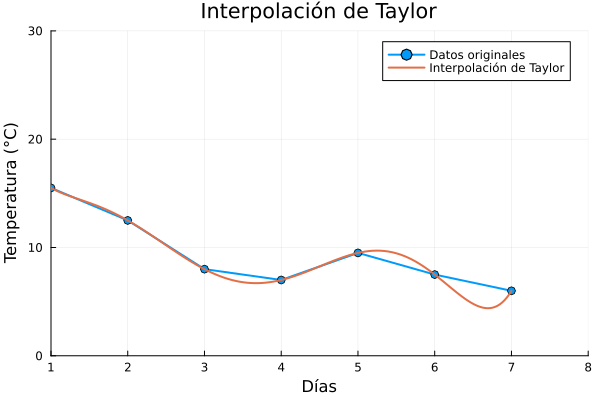

In [8]:
using Plots
using SymPy
using PyCall
np = pyimport("numpy")

#Temperaturas de prueba
baja = np.array([10,7,4,3,5,2,2]) #Temperaturas bajas 
alta = np.array([21,18,12,11,14,13,10]) #Temperaturas altas

#Declaramos el vector para guardar las temperaturas medias de cada dia
temp_medias=zeros(length(alta))

for i in 1:length(alta)
    temp_medias[i]= (alta[i]+baja[i])/2
end
print("Las temperaturas medias de cada dia son: ")
println(temp_medias)
#Declaramos el vector de dias
dias=1:length(temp_medias)

function Interpolacion_de_Taylor(temp_medias, dias,x0)
    x = symbols("x")
    n = length(dias)
    
    diferencias = [temp_medias]
    for i in 1:(n-1)
        push!(diferencias, diff(diferencias[end]))
    end
 
    # Construcción del polinomio de Taylor
    polinomio_de_Taylor = diferencias[1][1]
    factorial = 1
    for i in 1:(n-1)
        factorial *= i
        term = diferencias[i+1][1] / factorial
        for j in 0:(i-1)
            term *= (x - dias[j+1])
        end
        polinomio_de_Taylor += term
    end
    
    # Predicción en x0 que tomamos como 2.4
    prediccion = subs(polinomio_de_Taylor, x, x0)
    
    return polinomio_de_Taylor, prediccion,x0
end



taylor, prediccion, x0 = Interpolacion_de_Taylor(temp_medias, dias,2.4)


println("La predicción sobre el punto x0 es: $prediccion ")


# Graficacion
plot(dias, temp_medias, label="Datos originales", lw=2, marker=:o)
plot!(taylor, label="Interpolación de Taylor", lw=2)
xlabel!("Días")
ylabel!("Temperatura (°C)")
title!("Interpolación de Taylor")
ylims!(0, 30)
xlims!(1, 8)


---

## Interpolación de Lagrange

Temperatura de Tokyo: desde el día 23 al 29
Fuente: https://www.accuweather.com/es/jp/tokyo/226396/december-weather/226396?year=2023

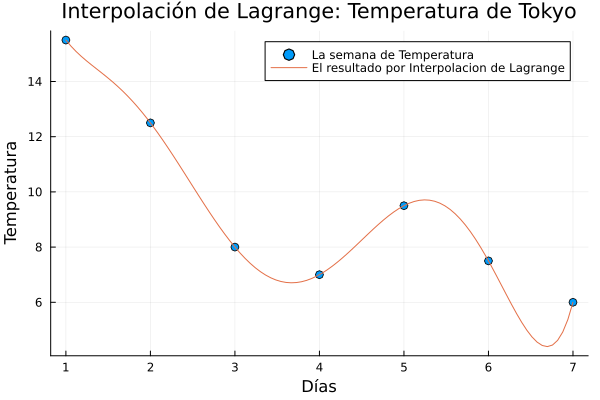

In [10]:
#=Importar libreria necesaria=#
using PyCall
using Plots
np = pyimport("numpy")

#=Datos de prueba=#
baja = np.array([10,7,4,3,5,2,2]) #=Temperatura baja=# 
alta = np.array([21,18,12,11,14,13,10]) #=Temperatura alta=#

#=Variables para trabajar:=#
dias = length(baja) #Esto es para contar cuanto dias
promedio_T = np.zeros(dias)
dias_lista = np.zeros(dias)

#Sacar promedio de temperatura
for i in 1:dias
    promedio_T[i]= (alta[i]+baja[i])/2
end

#=Contar cantidad de dias=#
j = 1
for i in 1:dias
    dias_lista[i] = j
    j = j + 1
end

#Procedimiento para el Interpolacion de Lagrange:

#Sacar el valor el vector "X":
menordias = np.min(dias_lista)
mayordias = np.max(dias_lista)
xpp = np.linspace(menordias, mayordias, 100)

#Sacar el valor el vector "Y":
ypp = np.zeros(length(xpp))
for i in 1:dias
    acum_p = np.ones(length(xpp)) #Para acumular el valor de y
    for j in 1:dias
        if i != j
            acum_p .*= ((xpp .- dias_lista[j] ) ./ (dias_lista[i]- dias_lista[j]))
        end
    end
    ypp .+= promedio_T[i] .* acum_p
end
#Colocar Fuente para Temperatura de Tokyo:
println("Temperatura de Tokyo: desde el día 23 al 29")
print("Fuente: https://www.accuweather.com/es/jp/tokyo/226396/december-weather/226396?year=2023")

#Grafica
scatter(dias_lista, promedio_T, marker=:o, label="La semana de Temperatura") #Ubicar los puntos sobre el dia y su correspondiente temperatura
plot!(xpp,ypp,label="El resultado por Interpolacion de Lagrange") #Graficar el vector
xlabel!("Días")
ylabel!("Temperatura")
title!("Interpolación de Lagrange: Temperatura de Tokyo")

---

## Interpolación de Hermite

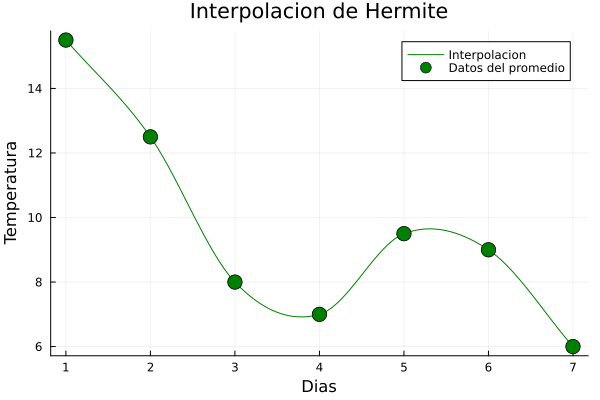

In [17]:
using PyCall
using Plots

np = pyimport("numpy")

function derivadas(x, y)
    n = length(x)
    dy = np.zeros(n)

    dy[1] = (y[2] - y[1]) / (x[2] - x[1])
    
    dy[end] = (y[end] - y[end-1]) / (x[end] - x[end-1])
    
    for i in 2:n-1
        dy[i] = (y[i + 1] - y[i - 1]) / (x[i + 1] - x[i - 1])
    end
    
    return dy
end

function encontrar_indices(x_interp, x_i, x_sig)
    indices = []
    for (i, val) in enumerate(x_interp)
        if x_i <= val <= x_sig
            push!(indices, i)
        end
    end
    return indices
end

function interpolacion_hermite(x, y, dy, x_interp)
    n = length(x)
    y_interp = np.zeros_like(x_interp)
    
    for i in 1:n-1
        h = x[i + 1] - x[i]
        
        t = (x_interp .- x[i]) / h
        
        h00 = 2 .* t.^3 .- 3 .* t.^2 .+ 1
        h10 = t.^3 .- 2 .* t.^2 .+ t
        h01 = -2 .* t.^3 .+ 3 .* t.^2
        h11 = t.^3 .- t.^2
    
        idx = encontrar_indices(x_interp, x[i], x[i + 1])
        
        for j in idx
            y_interp[j] = h00[j] * y[i] + h10[j] * h * dy[i] + h01[j] * y[i + 1] + h11[j] * h * dy[i + 1]
        end

    end
    return y_interp
end

# Lista de temperaturas
t_hot=[21.0,18.0,12.0,11.0,14.0,13.0,10.0]
t_cold=[10.0,7.0,4.0,3.0,5.0,5.0,2.0]

promedio = np.zeros(length(t_hot))

for i in 1:length(t_hot)
    promedio[i]= (t_hot[i]+t_cold[i])/2
end

# Generar puntos correspondientes
x = np.arange(1,length(promedio)+1)
y = np.array(promedio)

# Convertit x es un vector de tipo Float64 sí no lo es ya
x = convert(Vector{Float64}, x)

# Calcular derivadas
dy = derivadas(x, y)

# Puntos más finos para evaluación (las lineas)
x_fine = np.linspace(x[1], x[end], 100)
y_fine = interpolacion_hermite(x, y, dy, x_fine)


plot(x_fine, y_fine, label="Interpolacion",color=:green)
scatter!(x, y, label="Datos del promedio", color=:green, marker=:circle, markersize=8)
plot!(title = "Interpolacion de Hermite", xlabel = "Dias", ylabel = "Temperatura")



---

## Interpolación Polinómicas a Trozos

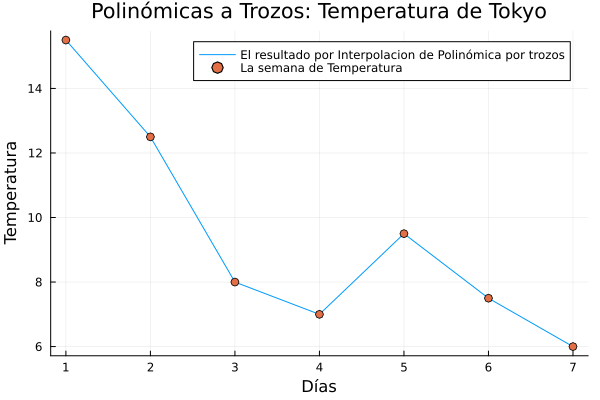

In [3]:
#=Importar libreria necesaria=#
using PyCall
using Plots
np = pyimport("numpy")

#=Datos de prueba=#
baja = np.array([10,7,4,3,5,2,2]) #=Temperatura baja=# 
alta = np.array([21,18,12,11,14,13,10]) #=Temperatura alta=#

#=Variables para trabajar:=#
dias = length(baja) #Esto es para contar cuanto dias
promedio_T = np.zeros(dias)
dias_lista = np.zeros(dias)

#Sacar promedio de temperatura
for i in 1:dias
    promedio_T[i]= (alta[i]+baja[i])/2
end

#=Contar cantidad de dias=#
j = 1
for i in 1:dias
    dias_lista[i] = j
    j = j + 1
end

#=Crear los tramos para la intepolacion=#
function interpolacion_polinomica_por_tramos(x, y)
    tramos = []

    # Iterar sobre los puntos para crear los segmentos
    for i in 1:(length(x)-1)
        m = (y[i+1] - y[i]) / (x[i+1] - x[i]) #la pendiente 
        b = y[i] - m * x[i] #el termino independiente
        push!(tramos, (m, b))
    end

    return tramos
end

#=Evaluar la interpolación en un conjunto de puntos=#
function evaluar_interpolacion(polinomios, x, puntos)
    y_interp = []

    for p in puntos
        for i in 1:(length(x)-1)
            if x[i] <= p <= x[i+1]
                # Evaluar el polinomio correspondiente
                coef = polinomios[i]
                y_val = coef[1] * p + coef[2]
                push!(y_interp, y_val)
                break
            end
        end
    end

    return y_interp
end

# Aplicar la interpolación polinómica por tramos
polinomios = interpolacion_polinomica_por_tramos(dias_lista, promedio_T)

# Crear un rango de puntos para evaluar la interpolación
puntos = collect(range(1, length(promedio_T), length=100))

# Evaluar la interpolación en los puntos
y_interp = evaluar_interpolacion(polinomios, dias_lista, puntos)

#Grafica
plot(puntos,y_interp,label="El resultado por Interpolacion de Polinómica por trozos") #Graficar el vector
scatter!(dias_lista, promedio_T, marker=:o, label="La semana de Temperatura") #Ubicar los puntos sobre el dia y su correspondiente temperatura
xlabel!("Días")
ylabel!("Temperatura")
title!("Polinómicas a Trozos: Temperatura de Tokyo")


<center><h2>¡¡GRACIAS!!</h2></center>